In [1]:
import pandas as pd
import numpy as np
import mord as m
from mord import LogisticAT
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns = 999
ML_data = pd.read_csv('ML_data.csv')
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_palette(sns.color_palette('Set1'))

Indirect binary classification

1. Seperate the dataframe into a features and label dataset
2. Break datasets down into training and test sets containing only unique mutations
3. Establish pipeline and parameter grid for model and grid search
4. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for ACCURACY
5. Produce confusion matrix with best parameters for ACCURACY
6. Convert predicted MIC to binary phenotype
7. Produce binary confusion matrix with best parameters for ACCURACY

1. Seperate the dataframe into a features and label dataset

In [2]:
MIC_ML_data = ML_data.dropna(subset = ['METHOD_MIC'])

In [3]:
MIC_strings = []

for i in MIC_ML_data['METHOD_MIC']:
    if i == '3.2':
        MIC_strings.append('>1.6')
    elif i == '6.4':
        MIC_strings.append('>1.6')
    elif i == '12.8':
        MIC_strings.append('>1.6')
    elif i == '>12.8':
        MIC_strings.append('>1.6')
    else:
        MIC_strings.append(i)
        
MIC_ML_data['MIC_values'] = MIC_strings

C:\Users\user\AppData\Local\Temp/ipykernel_26196/892947722.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MIC_ML_data['MIC_values'] = MIC_strings


In [4]:
MIC_df = MIC_ML_data[['MIC_values','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth','H','O','T','S','G','E',  \
              'B','I','Tempfactor','Hem_dist','Site2_dist','SNAP2_score']]

# creates features numpy array
MIC_features = MIC_df[MIC_df.columns[2:]].to_numpy()

#creates resistance label column
MIC_label = MIC_df['MIC_values'].to_numpy()

2. Break datasets down into training and test sets containing only unique mutations

In [5]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(MIC_features, MIC_label,
                                                    random_state=0)

In [6]:
# creates features and label dfs from unique mutations when the original train-test split 
# is inputted 
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MIC_VALUES'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #converts MIC_values to an integer so that the mean can be calculated for each mutation
    #with multiple samples
    MIC_integers = []

    for i in CV_train['MIC_VALUES']:
        if i == '<=0.025':
            MIC_integers.append(1)
        elif i == '0.05':
            MIC_integers.append(2)
        elif i == '0.1':
            MIC_integers.append(3)
        elif i == '0.2':
            MIC_integers.append(4)
        elif i == '0.4':
            MIC_integers.append(5)
        elif i == '0.8':
            MIC_integers.append(6)
        elif i == '1.6':
            MIC_integers.append(7)
        elif i == '>1.6':
            MIC_integers.append(8)
        
    CV_train['MIC_integers'] = MIC_integers

    #calculates the mean MIC value using the integer scale for each mutation
    MIC_calc_df = CV_train[['MUTATION','MIC_integers']].groupby('MUTATION').mean()
    
    #rounds the mean MIC value to the nearest integer for conversion back to the 
    #original MIC classes
    MIC_rounded = []
    for i in MIC_calc_df['MIC_integers']:
        rnd = round(i)
        MIC_rounded.append(rnd)
    MIC_calc_df['MIC_rounded'] = MIC_rounded

    # joins new MIC classes to CV_train df to replace the variation in MIC values associated
    # with mutations with multiple DST_measurements 
    MIC_calc_df.drop(['MIC_integers'], axis =1, inplace = True)
    CV_train.set_index('MUTATION', inplace = True)
    CV_train = CV_train.join(MIC_calc_df)
    CV_train.reset_index(inplace = True)
    CV_train.drop(['MIC_VALUES','MIC_integers'], axis = 1, inplace = True)
    CV_train.rename(columns = {'index':'MUTATION','MIC_rounded':'MIC_VALUES'}, inplace = True)
    
    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MIC_VALUES']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [7]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0, test_size=0.2
                                                               )

3. Establish pipeline and parameter grid for model and grid search

In [9]:
ordinal_IT = m.LogisticIT()
ordinal_AT = m.LogisticAT()

param_grid = {'alpha':[0.001,0.01,0.1,1,10,100,1000,10000]}

Continue for Intermediate threshold model (All threshold after)

4. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for ACCURACY

In [10]:
#Grid search with shuffled kfold cross validation
Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold = GridSearchCV(ordinal_IT, param_grid, cv=Kfold_shuffle, n_jobs=-1)
grid_kfold.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 LogisticIT(alpha=1000)
grid_kfold_shuffle: best cross-validation score:  0.3058467741935484
grid_kfold_shuffle: test set average accuracy:  0.35 



In [11]:
ordinal_IT = m.LogisticIT(alpha = 1000)

5. Produce confusion matrix with best parameters for ACCURACY

In [12]:
#copy and fit classifier with best parameters from previous section
ordinal = ordinal_IT
ordinal.fit(X_train_cv, y_train_cv)                 
                 
predict = ordinal.predict(X_test_nodup)

#generate confusion matrix
from sklearn.metrics import confusion_matrix
ints = [1,2,3,4,5,6,7,8]
confusion = confusion_matrix(y_test_nodup, predict, labels = ints)

print ('\n confusion matrix: \n', confusion)


 confusion matrix: 
 [[2 5 0 0 0 0 0 1]
 [6 3 0 0 0 0 0 0]
 [1 6 0 0 0 0 0 5]
 [0 7 0 0 0 0 0 6]
 [0 3 0 0 0 0 0 5]
 [0 2 0 0 0 0 0 6]
 [0 0 0 0 0 0 0 4]
 [0 4 0 0 0 0 0 9]]


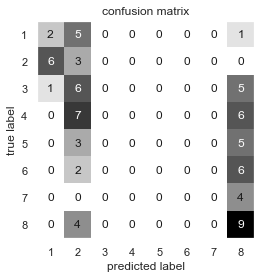

In [13]:
#generate heatmap of confusion matrix for visualisation
import mglearn

target_names = ints.copy()
scores_image = mglearn.tools.heatmap(confusion, xlabel='predicted label',
                                     ylabel='true label', xticklabels=target_names,
                                     yticklabels=target_names, cmap=plt.cm.gray_r, fmt='%d')
plt.title('confusion matrix')
plt.gca().invert_yaxis()

In [14]:
#generate classification report
from sklearn.metrics import classification_report

print (classification_report(y_test_nodup, predict, zero_division=True))

              precision    recall  f1-score   support

           1       0.22      0.25      0.24         8
           2       0.10      0.33      0.15         9
           3       1.00      0.00      0.00        12
           4       1.00      0.00      0.00        13
           5       1.00      0.00      0.00         8
           6       1.00      0.00      0.00         8
           7       1.00      0.00      0.00         4
           8       0.25      0.69      0.37        13

    accuracy                           0.19        75
   macro avg       0.70      0.16      0.09        75
weighted avg       0.68      0.19      0.11        75



6. Convert predicted MIC to binary phenotype

In [15]:
# will categorise multiclass data into 2 groups
def MIC_to_binary(data):
    RS_dict = {0:[4,5,6,7,8],
           1:[1,2,3]}
    binary_list = []
    for i in data:
        for k,v in RS_dict.items():
            for j in v:
                if i == j:
                    binary_list.append(k)

    binary_array = np.array(binary_list)
    return binary_array

7. Produce binary confusion matrix with best parameters for ACCURACY

Precision:  0.5897435897435898
Sensitivity:  0.7931034482758621
Specificity:  0.6521739130434783
FPR : 0.34782608695652173
very major error : 34.78260869565217
major error:  20.689655172413794

 confusion matrix: 
 [[30 16]
 [ 6 23]]


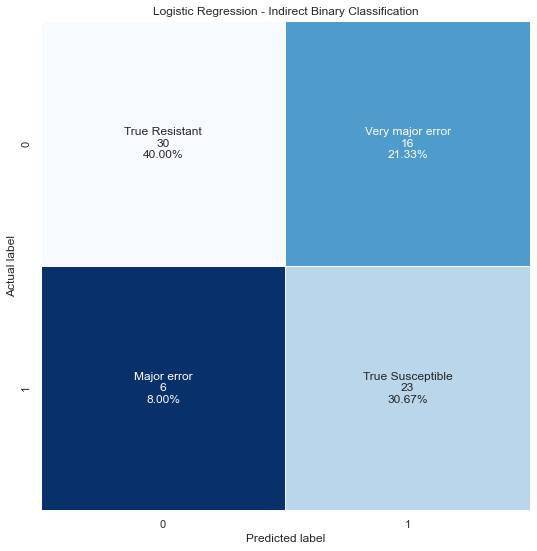

In [16]:
#generate confusion matrix
from sklearn import metrics
confusion = confusion_matrix(MIC_to_binary(y_test_nodup), MIC_to_binary(predict))
cm = metrics.confusion_matrix(MIC_to_binary(y_test_nodup), MIC_to_binary(predict))

#calculate precision, sensitivity, specificty, FPR, and errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/len(MIC_to_binary(y_test_nodup)[MIC_to_binary(y_test_nodup)==0]))*100
major_error = (confusion[1][0]/len(MIC_to_binary(y_test_nodup)[MIC_to_binary(y_test_nodup)==1]))*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

group_names = ['True Resistant','Very major error','Major error','True Susceptible']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=labels, fmt='', linewidths=.5, square = True, cmap = 'Blues_r', cbar=False);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Logistic Regression - Indirect Binary Classification');

#completes list of model quality values for model comparison
IT_multiclass_VME = very_major_error
IT_multiclass_ME = major_error

In [17]:
print (classification_report(MIC_to_binary(y_test_nodup), MIC_to_binary(predict)))

              precision    recall  f1-score   support

           0       0.83      0.65      0.73        46
           1       0.59      0.79      0.68        29

    accuracy                           0.71        75
   macro avg       0.71      0.72      0.70        75
weighted avg       0.74      0.71      0.71        75



Continue for All threshold model

4. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for ACCURACY

In [18]:
#Grid search with kfold cross validation (best cv for logreg multiclass classifcation)

Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold = GridSearchCV(ordinal_AT, param_grid, cv=Kfold_shuffle, n_jobs=-1)
grid_kfold.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 LogisticAT(alpha=10000)
grid_kfold_shuffle: best cross-validation score:  -1.8995967741935484
grid_kfold_shuffle: test set average accuracy:  0.175 



In [19]:
ordinal_AT = m.LogisticAT(alpha = 10000)

5. Produce confusion matrix with best parameters for ACCURACY

In [20]:
#copy and fit classifier with best parameters from previous section
ordinal = ordinal_AT
ordinal.fit(X_train_nodup, y_train_nodup)                 
                 
predict = ordinal.predict(X_test_nodup)

#generate confusion matrix
from sklearn.metrics import confusion_matrix
ints = [1,2,3,4,5,6,7,8]
confusion = confusion_matrix(y_test_nodup, predict, labels = ints)

print ('\n confusion matrix: \n', confusion)


 confusion matrix: 
 [[0 3 3 1 1 0 0 0]
 [1 5 1 2 0 0 0 0]
 [0 4 0 2 2 4 0 0]
 [0 2 3 1 2 5 0 0]
 [0 1 0 0 3 4 0 0]
 [0 1 0 0 3 4 0 0]
 [0 0 0 0 2 1 1 0]
 [0 0 0 4 3 5 1 0]]


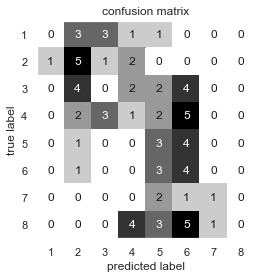

In [21]:
#generate heatmap of confusion matrix for visualisation
import mglearn

target_names = ints.copy()
scores_image = mglearn.tools.heatmap(confusion, xlabel='predicted label',
                                     ylabel='true label', xticklabels=target_names,
                                     yticklabels=target_names, cmap=plt.cm.gray_r, fmt='%d')
plt.title('confusion matrix')
plt.gca().invert_yaxis()

In [22]:
#generate classification report
from sklearn.metrics import classification_report

print (classification_report(y_test_nodup, predict, zero_division=True))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.31      0.56      0.40         9
           3       0.00      0.00      0.00        12
           4       0.10      0.08      0.09        13
           5       0.19      0.38      0.25         8
           6       0.17      0.50      0.26         8
           7       0.50      0.25      0.33         4
           8       1.00      0.00      0.00        13

    accuracy                           0.19        75
   macro avg       0.28      0.22      0.17        75
weighted avg       0.29      0.19      0.14        75



6. Convert predicted MIC to binary phenotype

In [23]:
# uses MIC_to_binary function defined in previous section

7. Produce binary confusion matrix with best parameters for ACCURACY

Precision:  0.7083333333333334
Sensitivity:  0.5862068965517241
Specificity:  0.8478260869565217
FPR : 0.15217391304347827
very major error : 15.217391304347828
major error:  41.37931034482759

 confusion matrix: 
 [[39  7]
 [12 17]]


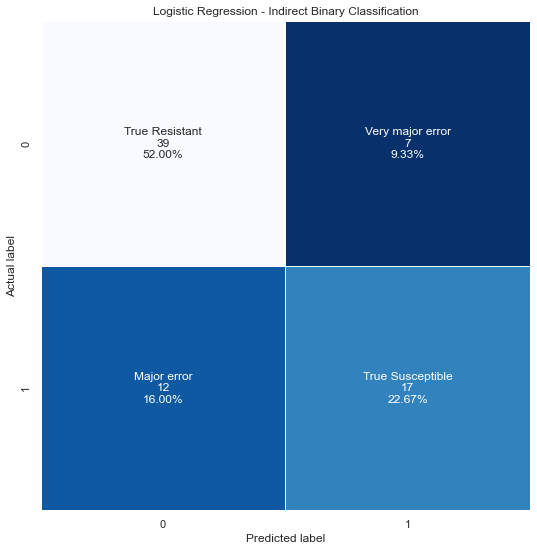

In [24]:
#generate confusion matrix
confusion = confusion_matrix(MIC_to_binary(y_test_nodup), MIC_to_binary(predict))
cm = metrics.confusion_matrix(MIC_to_binary(y_test_nodup), MIC_to_binary(predict))

#calculate precision, sensitivity, specificty, FPR, and errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/len(MIC_to_binary(y_test_nodup)[MIC_to_binary(y_test_nodup)==0]))*100
major_error = (confusion[1][0]/len(MIC_to_binary(y_test_nodup)[MIC_to_binary(y_test_nodup)==1]))*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

group_names = ['True Resistant','Very major error','Major error','True Susceptible']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=labels, fmt='', linewidths=.5, square = True, cmap = 'Blues_r', cbar=False);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Logistic Regression - Indirect Binary Classification');

#completes list of model quality values for model comparison
AT_multiclass_VME = very_major_error
AT_multiclass_ME = major_error

ORD_quality = [IT_multiclass_VME,IT_multiclass_ME,AT_multiclass_VME,AT_multiclass_ME]

ORD_quality_df = pd.DataFrame({'ORD_quality':ORD_quality})
ORD_quality_df.to_csv('ORD_quality.csv')

In [25]:
print (classification_report(MIC_to_binary(y_test_nodup), MIC_to_binary(predict)))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80        46
           1       0.71      0.59      0.64        29

    accuracy                           0.75        75
   macro avg       0.74      0.72      0.72        75
weighted avg       0.74      0.75      0.74        75



In [26]:
# all threshold model gives a better accuracy score - but still worse than RForest binary